# Univariate ARIMA Models

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [ ]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1]) # q stat measures if there is autocorrelation in residuals, if there is, that means model is not good as it failed to capture all info in data
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'  # adf tests for stationarity, if p-value < 0.05, we can reject null hypothesis that time series is non-stationary
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1]) # probability plot's purpose is to assess whether a data set follows a given distribution such as the normal or exponential distribution.
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4]) # moment measure shape of distribution, first moment is mean, second is variance, third is skewness, fourth is kurtosis
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [5]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

In [7]:
industrial_production

DATE
1988-01-01     55.7688
1988-02-01     56.9826
1988-03-01     57.7034
1988-04-01     57.9271
1988-05-01     58.0250
                ...   
2017-08-01    100.8011
2017-09-01    100.3878
2017-10-01    101.9380
2017-11-01    100.6758
2017-12-01     99.4968
Name: IPGMFN, Length: 360, dtype: float64

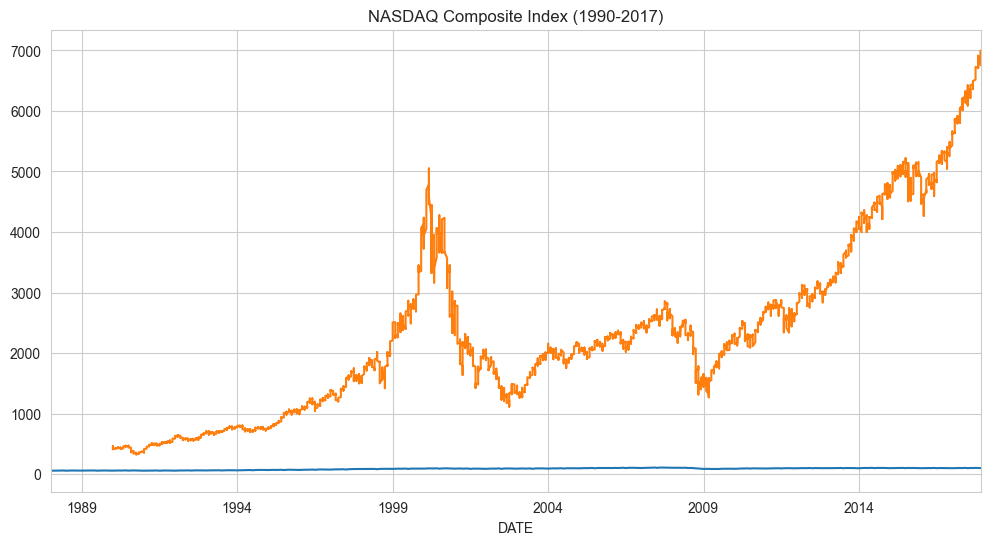

In [6]:
industrial_production.plot(title='Industrial Production Index (1988-2017)', figsize=(12, 6))
nasdaq.plot(title='NASDAQ Composite Index (1990-2017)', figsize=(12, 6))    
plt.show()

<Axes: title={'center': 'differenced'}, xlabel='DATE'>

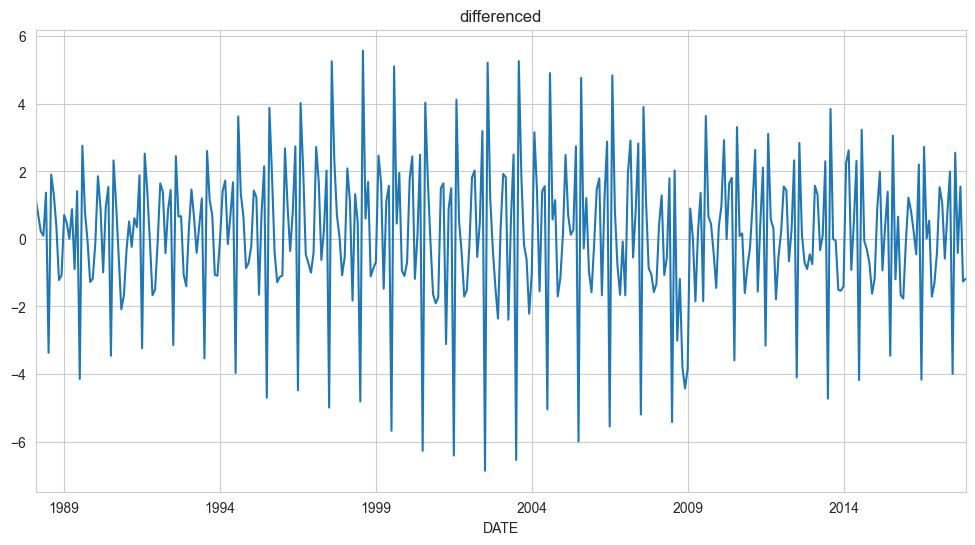

In [9]:
# lets do differencing and see if that helps with stationarity
industrial_production_diff = industrial_production.sort_index().diff().dropna()
industrial_production_diff.plot(title="differenced", figsize=(12,6))

<Axes: title={'center': 'differenced log'}, xlabel='DATE'>

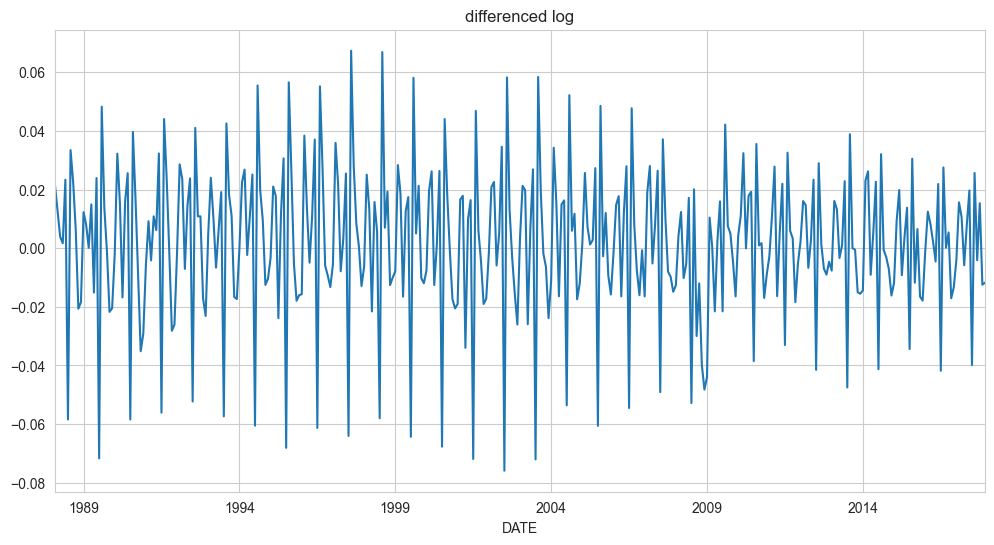

In [12]:
# comapred to diff only, we can see that there is only scale difference, we only really need log transform if variance scales with level
industrial_production_diff_log = industrial_production.sort_index().apply(np.log).diff().dropna()
industrial_production_diff_log.plot(title="differenced log", figsize=(12,6))

### Log Transformation

In [13]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

In [14]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


Chapter 8 introduces the ARIMA building blocks, simple autoregressive (AR) and moving average (MA) models, and explains how to combine them in autoregressive moving-average (ARMA) models that may account for series integration as ARIMA models or include exogenous variables as AR(I)MAX models. 

Furthermore, we will illustrate how to include seasonal AR and MA terms to extend the toolbox to also include SARMAX models.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [30]:
model1 = tsa.ARIMA(nasdaq_log_diff, order=(2,0,2), trend='n').fit()
model2 = tsa.ARIMA(nasdaq_log,      order=(2,1,2), trend='n').fit()


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. f

In [35]:
model1.params.sort_index().values 

array([-0.19154199, -0.17794814,  0.18443424,  0.13280638,  0.00021142])

In [36]:
model2.params.sort_index().values

array([-0.19154199, -0.17794814,  0.18443424,  0.13280638,  0.00021142])

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order (0,1,0,12).

In [22]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

In [23]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

SARIMAX      diff
ar.L1   1.768597  1.768597
ar.L2  -0.790875 -0.790875
ma.L1  -0.846313 -0.846313
ma.L2   0.316668  0.316668
sigma2  0.000101  0.000101

## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

In [42]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p,0, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

0 2


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

0 3


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

0 4


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

1 0


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

1 1


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

1 2


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

1 3


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

1 4


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

2 0


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

2 1


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

2 2


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

2 3


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

2 4


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

3 0


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

3 1


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

3 2


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

3 3


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

3 4


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

4 0


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

4 1


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

4 2


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

4 3


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

4 4


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

In [43]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [44]:
with pd.HDFStore('arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [45]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
2 4  0.009856 -755.248975 -732.949041          0.0           0.0
4 0  0.009936 -757.745544 -741.020594          0.0           0.0
  1  0.009950 -756.405677 -736.893235          0.0           0.0
2 2  0.010120 -757.215295 -740.490345          0.0           0.0
  3  0.010130 -757.494540 -737.982098          0.0           0.0

In [46]:
arma_results.nsmallest(5, columns=['BIC'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
4 0  0.009936 -757.745544 -741.020594          0.0           0.0
2 2  0.010120 -757.215295 -740.490345          0.0           0.0
  3  0.010130 -757.494540 -737.982098          0.0           0.0
4 1  0.009950 -756.405677 -736.893235          0.0           0.0
3 2  0.010225 -755.759050 -736.246607          0.0           0.0

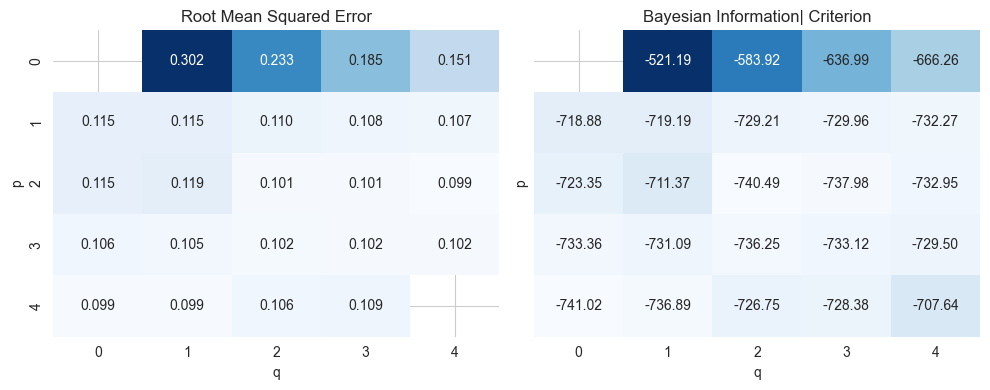

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information| Criterion')
fig.tight_layout();

In [68]:
arma_results.rank(axis = 0).loc[:, ['RMSE', 'BIC']].sum(1).nsmallest(5)

p  q
4  0    3.0
2  2    6.0
4  1    7.0
2  3    8.0
   4    9.0
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [69]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [71]:
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0,best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1105.904
Date:                Tue, 25 Nov 2025   AIC                          -2199.808
Time:                        16:38:25   BIC                          -2176.694
Sample:                    01-01-1989   HQIC                         -2190.606
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.010      1.864      0.062      -0.001       0.039
ar.L1          0.9318      0.044     21.009      0.000       0.845       1.019
ar.L2          0.3396      0.076      4.458      0.0

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Check Residual Correlogram

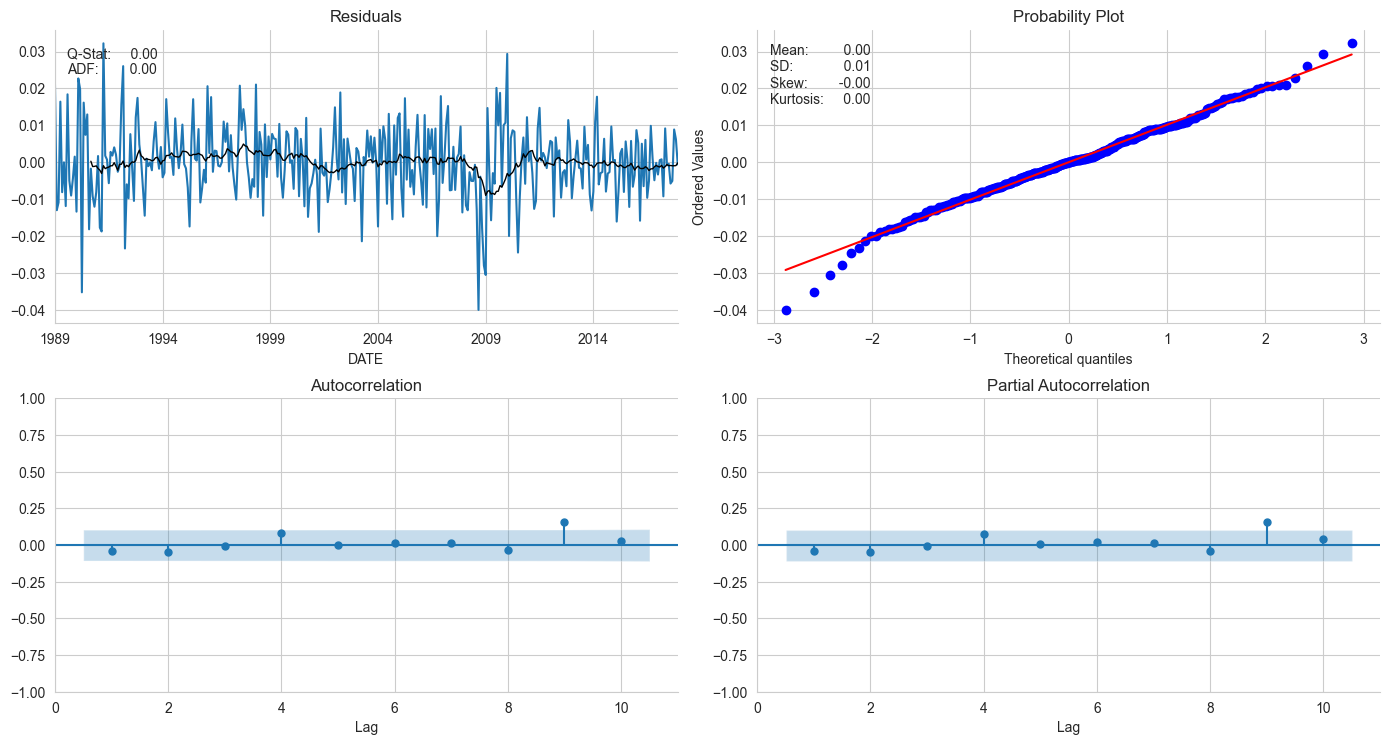

In [72]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [73]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1]) # [ar1, ar2, ma1, ma2, sar1, sma1, intercept]

In [74]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1126.884
Date:                              Tue, 25 Nov 2025   AIC                          -2239.768
Time:                                      17:41:45   BIC                          -2212.803
Sample:                                           0   HQIC                         -2229.033
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050      0.433      0.012      0.991      -0.845       0.855
ar.L2          0.99

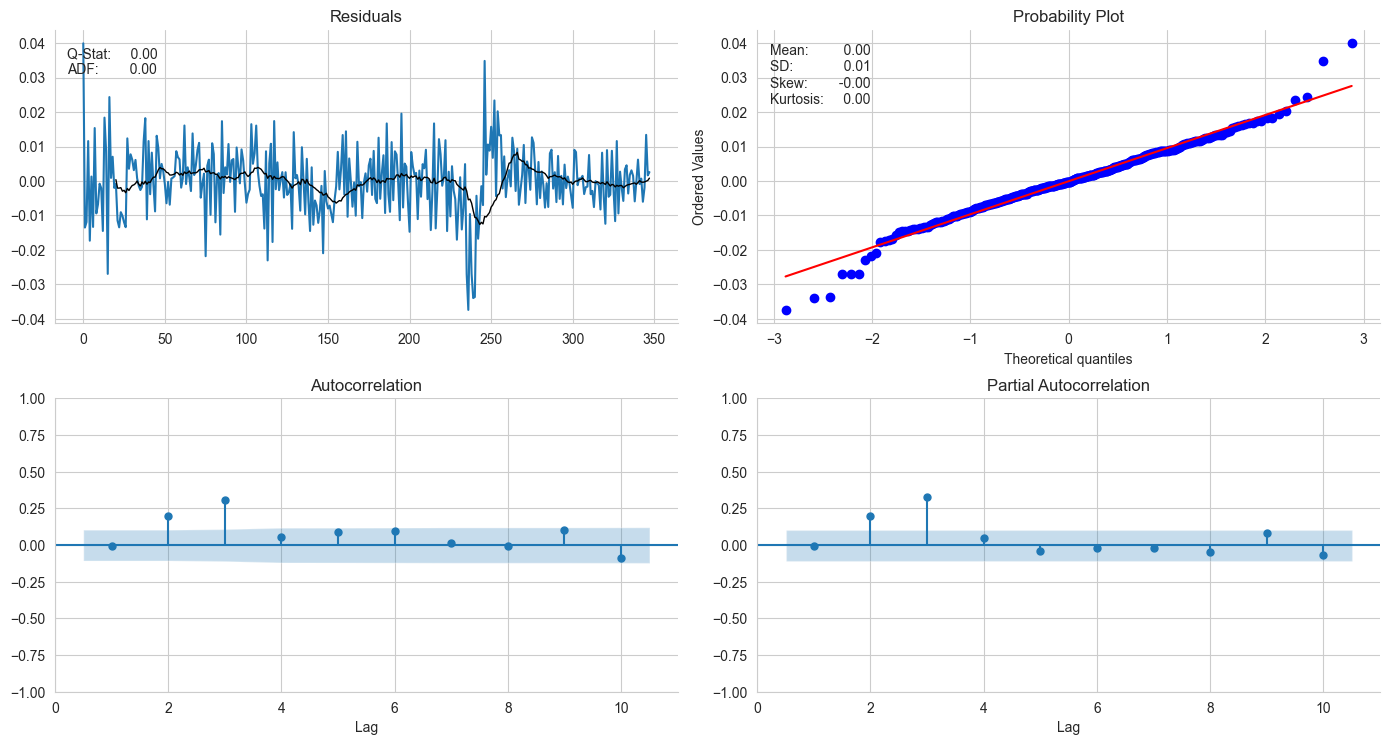

In [75]:
plot_correlogram(pd.Series(sarimax_model.resid))

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

This takes a while...

In [76]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [ ]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T-train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                order=(p1, 0, q1),
                                seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                      preds.y_true.sub(preds.y_pred).pow(2).std(),
                                      np.mean(aic),
                                      np.std(aic),                                                  
                                      np.mean(bic),
                                      np.std(bic),                                                  
                                      convergence_error,
                                      stationarity_error]

  1%|          | 1/81 [00:05<07:48,  5.86s/it]

### Compare model metrics

In [ ]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

In [ ]:
with pd.HDFStore('arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [ ]:
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [ ]:
sarimax_results.nsmallest(5, columns='RMSE')

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

In [ ]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [ ]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

### Train best model

In [ ]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [ ]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [ ]:
print(best_model.summary())

### Check Residual Correlogram

In [ ]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')